# Looking at EMNIST data

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.emnist import EMNIST

In [2]:
data = EMNIST()
data.prepare_data()
data.setup()
print(data)

EMNIST Dataset
Num classes: 83
Mapping: ['<B>', '<S>', '<E>', '<P>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '?']
Dims: (1, 28, 28)
Train/val/test sizes: 260212, 65054, 53988
Batch x stats: (torch.Size([128, 1, 28, 28]), torch.float32, tensor(0.), tensor(0.1738), tensor(0.3327), tensor(1.))
Batch y stats: (torch.Size([128]), torch.int64, tensor(4), tensor(65))



In [3]:
x, y = next(iter(data.test_dataloader()))
print(x.shape, x.dtype, x.min(), x.mean(), x.std(), x.max())
print(y.shape, y.dtype, y.min(), y.max())

torch.Size([128, 1, 28, 28]) torch.float32 tensor(0.) tensor(0.2215) tensor(0.3603) tensor(1.)
torch.Size([128]) torch.int64 tensor(4) tensor(4)


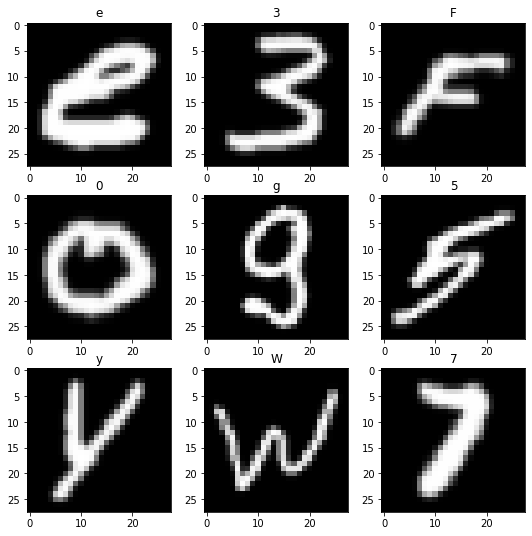

In [4]:
fig = plt.figure(figsize=(9, 9))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    rand_i = np.random.randint(len(data.data_test))
    image, label = data.data_test[rand_i]
    ax.imshow(image.reshape(28, 28), cmap='gray')
    ax.set_title(data.mapping[label])

## Train a CNN model

In [5]:
import pytorch_lightning as pl
from text_recognizer.models import CNN
from text_recognizer.lit_models import BaseLitModel

model = CNN(data_config=data.config())
lit_model = BaseLitModel(model=model)
trainer = pl.Trainer(gpus=1, max_epochs=5) # , accelerator="ddp"
trainer.fit(lit_model, datamodule=data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type     | Params
---------------------------------------
0 | model     | CNN      | 1.7 M 
1 | train_acc | Accuracy | 0     
2 | val_acc   | Accuracy | 0     
3 | test_acc  | Accuracy | 0     
---------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.616     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/2542 [00:00<?, ?it/s]                     

/home/elkhand/anaconda3/envs/fsdl-text-recognizer-2021/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/elkhand/anaconda3/envs/fsdl-text-recognizer-2021/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  80%|███████▉  | 2033/2542 [00:34<00:08, 59.60it/s, loss=0.602, v_num=3, val_loss=4.420, val_acc=0.0234]
Validating: 0it [00:00, ?it/s]
Epoch 1:  80%|███████▉  | 2033/2542 [00:36<00:09, 55.66it/s, loss=0.566, v_num=3, val_loss=0.583, val_acc=0.785]
Validating: 0it [00:00, ?it/s]
Epoch 1:  92%|█████████▏| 2340/2542 [00:39<00:03, 59.07it/s, loss=0.566, v_num=3, val_loss=0.583, val_acc=0.785]


Epoch 2:  80%|███████▉  | 2033/2542 [00:34<00:08, 58.67it/s, loss=0.535, v_num=3, val_loss=0.545, val_acc=0.796]
Validating: 0it [00:00, ?it/s]
Epoch 3:  80%|███████▉  | 2033/2542 [00:35<00:08, 57.51it/s, loss=0.502, v_num=3, val_loss=0.514, val_acc=0.805]
Validating: 0it [00:00, ?it/s]
Epoch 3:  88%|████████▊ | 2243/2542 [00:37<00:04, 60.26it/s, loss=0.502, v_num=3, val_loss=0.514, val_acc=0.805]


Epoch 4:  80%|███████▉  | 2033/2542 [00:35<00:08, 57.22it/s, loss=0.458, v_num=3, val_loss=0.505, val_acc=0.805]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 2542/2542 [00:39<00:00, 63.84it/s, loss=0.458, v_num=3, val_loss=0.497, val_acc=0.808]


1

In [6]:
x, y = next(iter(data.test_dataloader()))

logits = model(x)  # (B, C)
print(logits.shape)

preds = logits.argmax(-1)

print(y, preds)


torch.Size([128, 83])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4]) tensor([28,  4,  4,  4,  4, 28, 28,  4, 28,  4,  4,  4,  4, 28,  4,  4,  4,  4,
         4, 28,  4,  4,  4,  4, 28,  4,  4,  4,  4,  4,  4,  4,  4,  4, 28,  4,
        28, 28,  4,  4, 28, 28,  4,  4,  4,  4,  4,  4,  4,  4,  4, 28,  4, 17,
         4, 28,  4,  4, 28, 28,  4, 28,  4, 28,  4, 28, 28, 28,  4,  4,  4,  4,
         4, 28,  4,  4, 28,  4,  4, 28,  4,  4, 28,  4,  4,  4,  4,  4, 28, 28,
         4,  4,  4,  4,  4, 28,  4, 54,  4, 54,  4,  4,  4,  4,  4,  4,  4, 28,
        28, 28,  4,  4, 28,  4,  4, 28,  4, 28,  4,  4,  4,  4,  

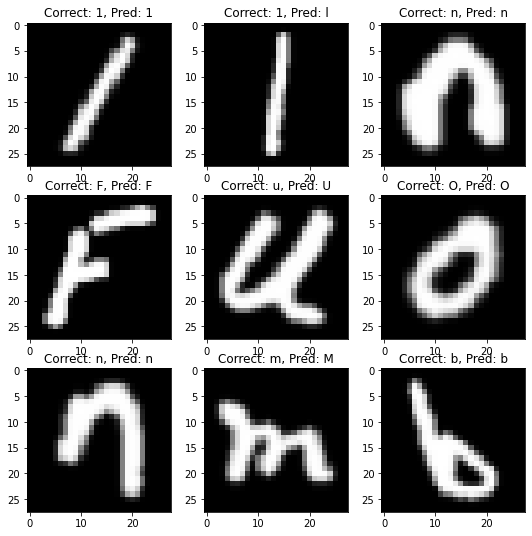

In [7]:

fig = plt.figure(figsize=(9, 9))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    rand_i = np.random.randint(len(data.data_test))
    image, label = data.data_test[rand_i]

    image_for_model = image.unsqueeze(0)  # (1, 1, 28, 28)
    logits = model(image_for_model)  # (1, C)
    pred_ind = logits.argmax(-1)  # (1, )
    pred_label = data.mapping[pred_ind]

    ax.imshow(image.reshape(28, 28), cmap='gray')
    ax.set_title(f'Correct: {data.mapping[label]}, Pred: {pred_label}')
